In [10]:
from pathlib import Path
import torch
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import numpy as np
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from torchinfo import summary

In [17]:
import torchvision.models as models
import torchvision
import torch.nn as nn
from torch import Tensor
from torchvision.models.resnet import BasicBlock
import torch.optim as optim


In [18]:
path = Path('.')

In [19]:
class Unet_ResNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_input = nn.Sequential(nn.Conv2d(in_channels=3, out_channels=64, kernel_size=1, stride=1, padding=0),
                                  nn.ReLU(inplace=True))
        layers = []
        for _ in range(0, 5):
            layers.append(BasicBlock(64, 64))
        self.blocks = nn.Sequential(*layers)
        
        self.conv_end = nn.Sequential( nn.Conv2d(in_channels=64, out_channels=3, kernel_size=1, stride=1, padding=0),
                                  nn.ReLU(inplace=True))
        #Reference source code for initialization of Batch Norm and Conv2d https://pytorch.org/vision/0.8/_modules/torchvision/models/resnet.html
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
    def forward(self, x: Tensor) -> Tensor:
        x = self.conv_input(x)
        x = self.blocks(x)
        x = self.conv_end(x)
        return x

In [21]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [22]:
#Get the CIFAR dataset in
data = torchvision.datasets.CIFAR10(root = path/'data', download = True, transform=transform)

Files already downloaded and verified


In [23]:
len(data)

50000

In [24]:
#Sample one image
img, label = data.__getitem__(0)

In [25]:
type(img)

torch.Tensor

In [26]:
def imshow(img):
    img = img/2 + 0.5
    img_np = img.numpy()
    plt.imshow(np.transpose(img_np, (1, 2, 0)))
    plt.show()

In [27]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [28]:
img = TF.rotate(img, -90)

In [29]:
#Gotta add an arrow to this numpy matrix
img.numpy()

array([[[ 0.38823533,  0.41176474,  0.6313726 , ..., -0.8039216 ,
         -0.8745098 , -0.5372549 ],
        [ 0.3176471 ,  0.35686278,  0.5764706 , ..., -0.8745098 ,
         -1.        , -0.6627451 ],
        [ 0.4039216 ,  0.45882356,  0.5529412 , ..., -0.6156863 ,
         -0.85882354, -0.60784316],
        ...,
        [ 0.69411767,  0.4431373 ,  0.254902  , ..., -0.0745098 ,
         -0.03529412,  0.23921573],
        [ 0.18431377, -0.23921567, -0.56078434, ..., -0.05882353,
         -0.06666666,  0.19215691],
        [-0.03529412, -0.3490196 , -0.58431375, ..., -0.14509803,
         -0.04313725,  0.16078436]],

       [[ 0.12941182,  0.09019613,  0.33333337, ..., -0.8117647 ,
         -0.84313726, -0.5137255 ],
        [ 0.01176476, -0.03529412,  0.20000005, ..., -0.94509804,
         -1.        , -0.6392157 ],
        [ 0.11372554,  0.12941182,  0.26274514, ..., -0.7882353 ,
         -0.9372549 , -0.62352943],
        ...,
        [ 0.4431373 ,  0.16078436,  0.04313731, ..., -

frog


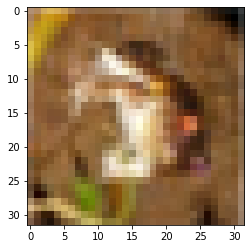

In [30]:
print(classes[label])
imshow(img)

In [31]:
#Sample one image
img, label = data.__getitem__(0)

In [32]:
def add_arrow(img):
    start = 2
    for i in range(start,start+7):
        img[:,i,start+6] = 0
    for i in range(start+5,start+8):
        img[:,start+1,i] = 0
    for i in range(start+4,start+9):
        img[:,start+2,i] = 0
    return img

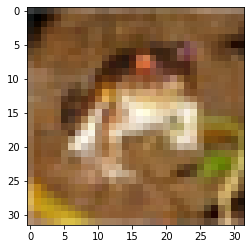

In [33]:
imshow(img)

In [34]:
class arrowedCIFAR(Dataset):
    """Make CIFAR with arrow"""

    def __init__(self, train=True):
        transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
        self.train = train
        if self.train:
            self.cifar = torchvision.datasets.CIFAR10(root = path/'data', download = True, transform=transform, train = True)
        else:
            self.cifar = torchvision.datasets.CIFAR10(root = path/'data', download = True, transform=transform, train = False)
        self.data = []
        self.labels = []
        for i in tqdm(range(len(self.cifar))):
            self.data.append(add_arrow(self.cifar.__getitem__(i)[0])) #Only care about the rotation
            self.labels.append(0)
            for k, angle in enumerate([90, 180, 270]):
                img = add_arrow(self.cifar.__getitem__(i)[0])
                self.data.append(TF.rotate(img, angle))
                self.labels.append(k+1) #Add the rest of labels
            
    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

In [35]:
batch_size = 32
trainset = arrowedCIFAR(train=True)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=4)
testset = arrowedCIFAR(train=False)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                          shuffle=True, num_workers=4)


Files already downloaded and verified


100%|███████████████████████████████████████████████████████████████████████████| 50000/50000 [02:01<00:00, 412.47it/s]


Files already downloaded and verified


100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 376.82it/s]


In [36]:
img, label = trainset.__getitem__(5)

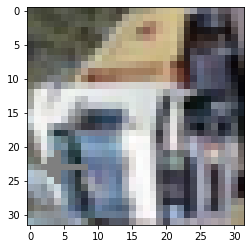

In [37]:
imshow(img)

In [38]:
#Sample one image
img, label = data.__getitem__(0)

In [40]:
batch_size = 1
summary(model, input_size=(batch_size, 3, 28, 28))

Layer (type:depth-idx)                        Output Shape              Param #
Lens_Network                                  --                        --
├─Unet_ResNet: 1-1                            [1, 3, 28, 28]            --
│    └─Sequential: 2-1                        [1, 64, 28, 28]           --
│    │    └─Conv2d: 3-1                       [1, 64, 28, 28]           256
│    │    └─ReLU: 3-2                         [1, 64, 28, 28]           --
│    └─Sequential: 2-2                        [1, 64, 28, 28]           --
│    │    └─BasicBlock: 3-3                   [1, 64, 28, 28]           73,984
│    │    └─BasicBlock: 3-4                   [1, 64, 28, 28]           73,984
│    │    └─BasicBlock: 3-5                   [1, 64, 28, 28]           73,984
│    │    └─BasicBlock: 3-6                   [1, 64, 28, 28]           73,984
│    │    └─BasicBlock: 3-7                   [1, 64, 28, 28]           73,984
│    └─Sequential: 2-3                        [1, 3, 28, 28]            --

In [63]:
def recon_loss(raw_inputs, lens_output):
    loss = nn.MSELoss(reduction = 'sum')
    return loss(raw_inputs,lens_output)

In [64]:
def lens_loss(ssl_loss, raw_inputs, lens_output, lambda_term = 0.01):
    #Adevrsarial loss
    total_loss = -ssl_loss + lambda_term*recon_loss(raw_inputs, lens_output)
    return total_loss

In [65]:
loss = nn.MSELoss(reduction = 'sum') 
loss(torch.randn(2, 2,3),torch.randn(2, 2,3))

tensor(38.1903)

In [72]:
class Resnet_FC4(nn.Module):
    def __init__(self):
        super().__init__()
        #Feature extraction
        res = models.resnet50()
        res.fc = torch.nn.Linear(in_features=2048, out_features=4, bias=True)
        self.res = res
    def forward(self, x: Tensor) -> Tensor:
        x = self.res(x)
        return x

In [77]:
model1 = Unet_ResNet()
optim1 = optim.Adam(model1.parameters(), lr=0.001)
model2 = Resnet_FC4()
optim2 = optim.Adam(model2.parameters(), lr=0.001)

In [78]:
class Lens_Network(nn.Module):
    def __init__(self):
        super().__init__()
        #Lens component
        self.lens = Unet_ResNet()
        
        #Feature extraction
        res = models.resnet50()
        res.fc = torch.nn.Linear(in_features=2048, out_features=4, bias=True)
        self.res = res
        
    def forward(self, x: Tensor) -> Tensor:
        orig = x
        lens_output = self.lens(x)
        x = lens_output + orig
        x = self.res(x)
        return lens_output, x

In [79]:
criterion = nn.CrossEntropyLoss()

In [80]:
for epoch in range(10):
    ssl_losses = 0.0
    lens_losses = 0.0
    for i, data in enumerate(trainloader):
        inputs, labels = data
        lens_output = model1(inputs)
        x = torch.add(lens_output, inputs)
        outputs = model2(x)
        #Calculate separate loss
        ssl_loss = criterion(outputs, labels)
        l_loss = lens_loss(ssl_loss, inputs, lens_output, lambda_term = 0.01)
        loss = ssl_loss + l_loss
        loss.backward()
        
        #Update weights
        optim1.step()
        optim1.zero_grad()
        optim2.step()
        optim2.zero_grad()
        ssl_losses += ssl_loss.item()
        lens_losses += l_loss.item()
        if i>0 and i % 50 == 0:    # print every 2000 mini-batches
            print(f'[{epoch}, batch {i}] ssl_loss: {ssl_losses / i:.3f} lens_loss: {lens_losses / i:.3f}')
            running_loss = 0.0

print('Finished Training')

[0, batch 50] ssl_loss: 1.658 lens_loss: 6577.770
[0, batch 100] ssl_loss: 1.645 lens_loss: 3412.790
[0, batch 150] ssl_loss: 1.653 lens_loss: 2356.651
[0, batch 200] ssl_loss: 1.654 lens_loss: 1829.688
[0, batch 250] ssl_loss: 1.655 lens_loss: 1513.937
[0, batch 300] ssl_loss: 1.652 lens_loss: 1302.227
[0, batch 350] ssl_loss: 1.650 lens_loss: 1151.991
[0, batch 400] ssl_loss: 1.647 lens_loss: 1038.695
[0, batch 450] ssl_loss: 1.649 lens_loss: 950.621
[0, batch 500] ssl_loss: 1.652 lens_loss: 880.650
[0, batch 550] ssl_loss: 1.652 lens_loss: 822.792
[0, batch 600] ssl_loss: 1.654 lens_loss: 774.275


KeyboardInterrupt: 

### Coding for the color aberration

In [ ]:
img_zeros = np.zeros((3,32,32))

In [ ]:
img_zeros[2,:,:] = img[2,:,:]
img_zeros[0,:,:] = img[0,:,:]

In [ ]:
move = 1

In [ ]:
img_zeros[1,:,move:32] = img[1,:,0:32-move]
img_zeros[1,:,0:move] = img[1,:,32-move:32] #Shifting up

In [ ]:
img_zeros.shape

In [ ]:
img_zeros = img_zeros/2 + 0.5
plt.imshow(np.transpose(img_zeros, (1, 2, 0)))
plt.show()

In [ ]:
imshow(img)